## Project Description:
This data is about marketing funnels - Digital funnels

## Research Task:
- Find out which funnel is the most succsefull in terms of revenue -(LTV (Lifetime value))
- Find out which funnel is the worst in terms of Customer Aquisition 

### Libraries

In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import spearmanr
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from textblob import TextBlob



warnings.filterwarnings('ignore')


### Data loading & Overview

In [144]:
# Asin_PATH = '/Users/Matvej1/CyberPro/Python_main/Python_Data_Analytic_project/DATA/search_results.csv'
# Review_PATH = '/Users/Matvej1/CyberPro/DATA/all_reviews.csv'
sales_path = '/Users/Matvej1/CyberPro/Python_main/Python_Data_Analytic_project/DATA/output total synccentric.csv'
# df = pd.read_csv(Review_PATH)
# df.info()
# df_asin = pd.read_csv(Asin_PATH)
df_sales = pd.read_csv(sales_path)
df_sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 222 entries, initial_identifier to imported_asin
dtypes: float64(149), int64(4), object(69)
memory usage: 173.6+ KB


In [ ]:


# Drop rows where the review body is missing
df_sales = df.dropna(subset=['body'])

# Drop duplicates based on author, title, date, and body text
df = df.drop_duplicates(subset=['author', 'title', 'date', 'body'])

# Strip whitespace from review title and body
df_sales['body'] = df['body'].astype(str).str.strip()
df_sales['title'] = df['title'].astype(str).str.strip()

# Convert the 'date' column to datetime format
df_sales['date'] = pd.to_datetime(df['date'], errors='coerce')

# Show the number of missing values in each column
print("Missing values per column:")
print(df.isnull().sum())

# Show the final number of reviews after cleaning
print(f"Total number of cleaned reviews: {df.shape[0]}")

min_date = df['date'].min()
max_date = df['date'].max()

asin_titles = df_asin[['asin', 'title']].copy()
asin_titles['product_name'] = asin_titles['title'].str.slice(0, 50)
df = df.merge(asin_titles[['asin', 'product_name']], on='asin', how='left')
df.head()

print(f"Date range of reviews: {min_date.date()} to {max_date.date()}")



Missing values per column:
asin                 0
author               0
location             0
date                 0
rating               0
title                0
body                 0
verified_purchase    0
helpful_votes        0
product_name         0
sentiment            0
dtype: int64
Total number of cleaned reviews: 4392
Date range of reviews: 2024-02-27 to 2025-08-01


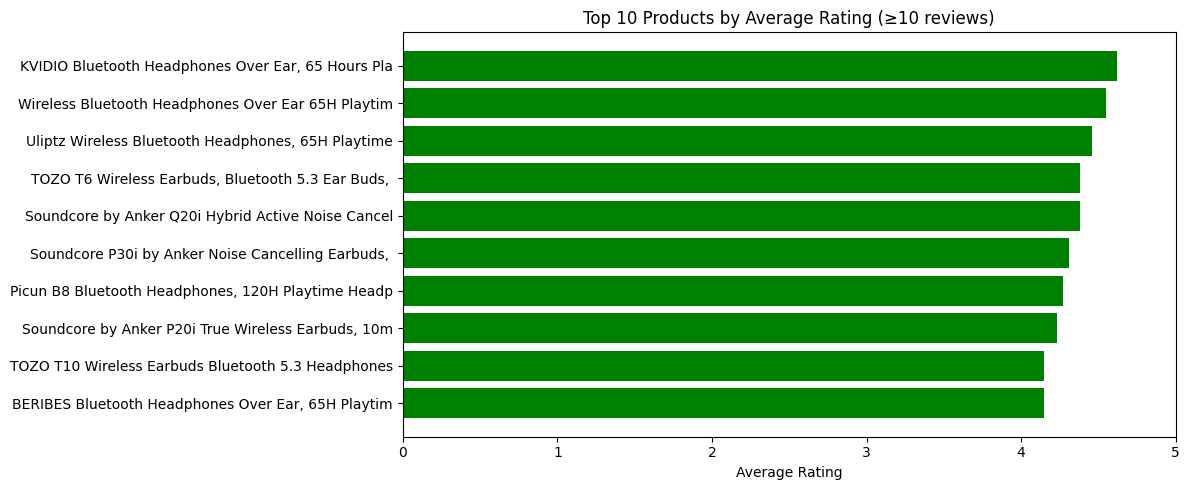

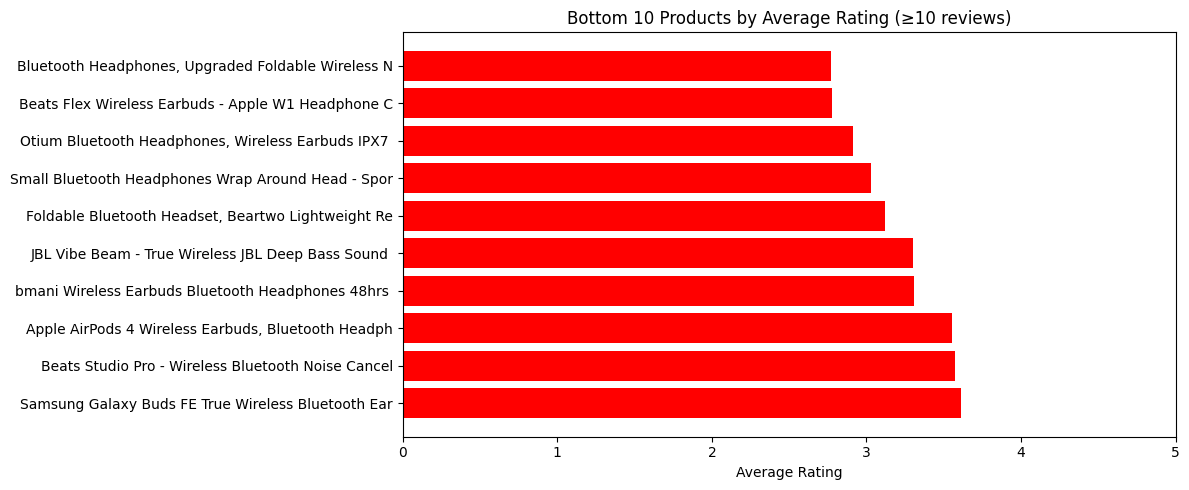

In [132]:
# Группировка по ASIN
asin_ratings = df.groupby('asin').agg(
    avg_rating=('rating', 'mean'),
    review_count=('rating', 'count')
).reset_index()

# Фильтрация по количеству отзывов
asin_ratings = asin_ratings[asin_ratings['review_count'] >= 10]

# Добавим название продукта из df
asin_ratings = asin_ratings.merge(
    df[['asin', 'product_name']].drop_duplicates(subset='asin'),
    on='asin',
    how='left'
)


import matplotlib.pyplot as plt

# Top 10 highest rated ASINs
import matplotlib.pyplot as plt

# Топ и анти-топ
top_rated = asin_ratings.sort_values('avg_rating', ascending=False).head(10)
low_rated = asin_ratings.sort_values('avg_rating').head(10)

# Top 10
plt.figure(figsize=(12, 5))
plt.barh(top_rated['product_name'], top_rated['avg_rating'], color='green')
plt.xlabel('Average Rating')
plt.title('Top 10 Products by Average Rating (≥10 reviews)')
plt.xlim(0, 5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Bottom 10
plt.figure(figsize=(12, 5))
plt.barh(low_rated['product_name'], low_rated['avg_rating'], color='red')
plt.xlabel('Average Rating')
plt.title('Bottom 10 Products by Average Rating (≥10 reviews)')
plt.xlim(0, 5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



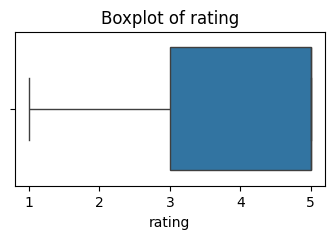

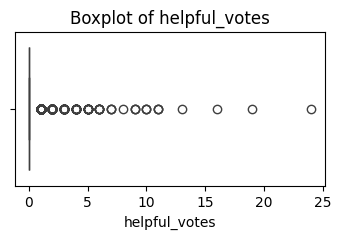

In [114]:
#BOX PLOT FOR INITIAL OUTLIER VISUALIZATION
def create_boxplots(df):
    numerical_cols = df.select_dtypes(include=['number']).columns
    for col in numerical_cols:
        plt.figure(figsize=(4, 2))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

create_boxplots(df)

In [115]:
#UNIQUE VALUES OBSERVATION

def print_unique_categorical(df):
    for col in df.columns:
        # Check if the column's data type is object or categorical (non-numerical)
        if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col]):
            print(f"Unique values in column '{col}':")
            print(df[col].unique())
            print("\n")

print_unique_categorical(df)

Unique values in column 'asin':
['B07J2Z5DBM' 'B0F53L8J78' 'B09FT58QQP' 'B08HMWZBXC' 'B08WM3LMJF'
 'B0BTYCRJSS' 'B0863TXGM3' 'B08L6ZYW21' 'B08H1WNYTR' 'B09FLNSYDZ'
 'B085296FLT' 'B09LYF2ST7' 'B0DD41G2NZ' 'B018APC4LE' 'B0CQXMXJC5'
 'B0D1XD1ZV3' 'B09CPDSNQM' 'B09BF64J55' 'B0BQPNMXQV' 'B07KQ38L2B'
 'B0C8PR4W22' 'B0BS1PRC4L' 'B0C3W4MNN1' 'B0CSXV3GK4' 'B07XFMKMLG'
 'B07MQQS88Q' 'B0CZPGX972' 'B07FGFNP48' 'B0CX1SZPH3' 'B09NNBBY8F'
 'B09YLFHFDW' 'B0DGHMNQ5Z' 'B0BFQS8236' 'B0BS1QCFHX' 'B0CRTR3PMF'
 'B09KGLRF8J' 'B0BMLXSNG8' 'B0BG28NB7S' 'B09CYL1C2X' 'B0CFV9XR2Q'
 'B0CTBCDD6D' 'B0CF7GYNW2' 'B09BHXKNBB' 'B0D2XRXNGY']


Unique values in column 'author':
['MR. GEE MANN' 'TDodge' 'Jimmy' ... 'Not A Robot!' 'Amanda R'
 'ignacio Ballerio']


Unique values in column 'location':
['the United States']


Unique values in column 'title':
['5.0 out of 5 starsEasy to use holds a charge.'
 '4.0 out of 5 starsInconsistency is annoying'
 '5.0 out of 5 starsAmazing for a long time till now' ...
 '5.0 out of 5 st

#### Description & Conclusions:
- We have 15 numerical columns etc
- Min value for age is 0.42 - to be checked
- We have 107 duplicated rows
- We have Nulls in age,deck,embarked & embarked_town columns

## Preprocessing

In [12]:
### TREAT NULLS, DULPICATES , ILLOGICAL VALUES, OUTLIERS, DATATYPES, COLUMN NAMING (IF U HAVE SPACES OR UPPER CASE)

<div style="background-color:#87CEFA;color:black;padding:10px;">
  <h1>Data Types Fixing</h1>
</div>

- There are no changes to be done in the dataset (dtypes are correct and memory usage is very low)

#### Duplicates & Nulls

#### Illogical Values

In [ ]:
#UNIQUE VALUES FOR CATEGORICAL COLUMN (NOT PRICE etc)
#HELPFUL FOR DECIDING THE OUTLIER THRESHOLD FOR SPECIFIC COLUMNS

In [133]:
df.columns = df.columns.astype(str).str.strip()

# Проверим список колонок
print(df.columns.tolist())

df.head()




['asin', 'author', 'location', 'date', 'rating', 'title', 'body', 'verified_purchase', 'helpful_votes', 'product_name']


,asin,author,location,date,rating,title,body,verified_purchase,helpful_votes,product_name
0,B07J2Z5DBM,MR. GEE MANN,the United States,2025-07-31,5.0,5.0 out of 5 starsEasy to use holds a charge.,"These are easy to use, good price and easy to ...",True,0,TOZO T10 Wireless Earbuds Bluetooth 5.3 Headph...
1,B07J2Z5DBM,TDodge,the United States,2025-07-31,4.0,4.0 out of 5 starsInconsistency is annoying,Really happy with these Tozo T10 Bluetooth ear...,True,0,TOZO T10 Wireless Earbuds Bluetooth 5.3 Headph...
2,B07J2Z5DBM,Jimmy,the United States,2025-07-31,5.0,5.0 out of 5 starsAmazing for a long time till...,I have had this for a while now (I think I hav...,True,0,TOZO T10 Wireless Earbuds Bluetooth 5.3 Headph...
3,B07J2Z5DBM,Amazon Customer,the United States,2025-07-31,2.0,"2.0 out of 5 starsGood, but need a lot of work….",I’ve owned these for a year… the quality of th...,False,0,TOZO T10 Wireless Earbuds Bluetooth 5.3 Headph...
4,B07J2Z5DBM,Kindle Customer,the United States,2025-07-31,5.0,5.0 out of 5 starsGreat product,Great bargain better than my more expensive se...,True,0,TOZO T10 Wireless Earbuds Bluetooth 5.3 Headph...


### Outliers

CONSIDER TO COMPARE YOUR ANALYSIS WITH AND WITHOUT OUTLIERS, DEPENDING ON THE AMOUNT AND THE IMPACT

#### Z-Score - 

how many standard deviations a data point is away from the mean. Typically, a data point is considered an outlier if its Z-score is greater than 3 or less than -3.

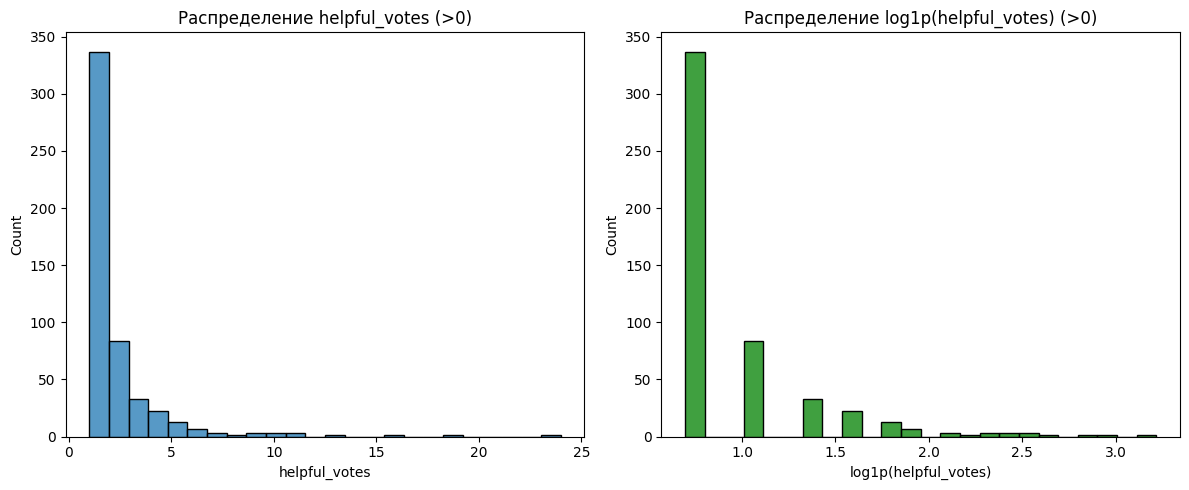

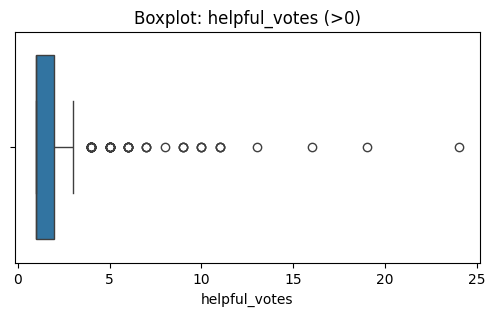

Z-score > 4: 7 outliers
Quantile > 0.99 (>11.0): 4 outliers

Top 5 отзывов по helpful_votes:
            asin        author           location       date  rating  \
3090  B09YLFHFDW        wali h  the United States 2025-05-15     5.0   
1074  B085296FLT        Lmhugg  the United States 2025-05-28     5.0   
1175  B09LYF2ST7  Honey Badger  the United States 2025-07-24     5.0   
91    B07J2Z5DBM   Bridgette77  the United States 2025-07-10     5.0   
2892  B0CX1SZPH3     Christina  the United States 2025-07-10     1.0   

                                                  title  \
3090  5.0 out of 5 starsGreat wireless neckband earp...   
1074                   5.0 out of 5 starsSaved my life!   
1175          5.0 out of 5 starsSeems amazing so far :)   
91    5.0 out of 5 starsWow! These are amazing, and ...   
2892  1.0 out of 5 starsPlease read this.  NOT NOISE...   

                                                   body  verified_purchase  \
3090  I've used its cousin, the WI-C130, 

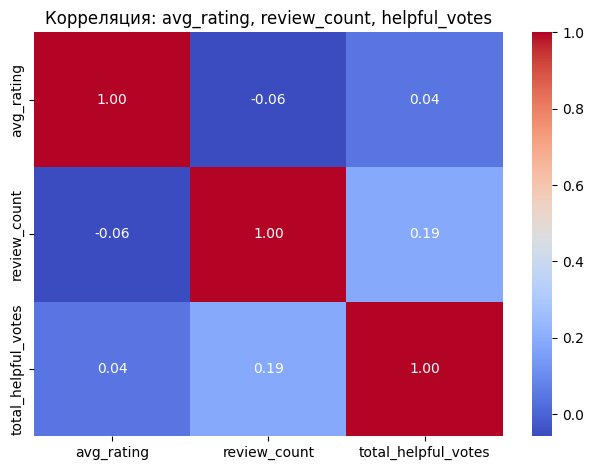

In [127]:


# Подготовка: фильтруем ненулевые значения
df_nonzero = df[df['helpful_votes'] > 0].copy()
df_nonzero['log_helpful_votes'] = np.log1p(df_nonzero['helpful_votes'])

# ==== 1. Визуализация распределения ====
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_nonzero['helpful_votes'], bins=24)
plt.title('Распределение helpful_votes (>0)')
plt.xlabel('helpful_votes')

plt.subplot(1, 2, 2)
sns.histplot(df_nonzero['log_helpful_votes'], bins=24, color='green')
plt.title('Распределение log1p(helpful_votes) (>0)')
plt.xlabel('log1p(helpful_votes)')

plt.tight_layout()
plt.show()


# ==== 2. Boxplot ====
plt.figure(figsize=(6, 3))
sns.boxplot(x=df_nonzero['helpful_votes'])
plt.title('Boxplot: helpful_votes (>0)')
plt.show()


# ==== 3. Анализ выбросов по Z-score ====
df_nonzero['zscore'] = zscore(df_nonzero['helpful_votes'])
z_thresh = 4  # <== Можешь менять этот порог
outliers_z = df_nonzero[df_nonzero['zscore'] > z_thresh]

# ==== 4. Анализ выбросов по квантилям ====
q_thresh = 0.99  # <== Можно менять на 0.95, 0.98 и т.д.
q_value = df_nonzero['helpful_votes'].quantile(q_thresh)
outliers_q = df_nonzero[df_nonzero['helpful_votes'] > q_value]

# ==== 5. Просмотр результатов ====
print(f'Z-score > {z_thresh}: {len(outliers_z)} outliers')
print(f'Quantile > {q_thresh} (>{q_value}): {len(outliers_q)} outliers')

# Примеры top-N
print("\nTop 5 отзывов по helpful_votes:")
print(df_nonzero.sort_values('helpful_votes', ascending=False).head(5))

if {'asin', 'rating', 'helpful_votes'}.issubset(df.columns):
    df_grouped = df.groupby('asin').agg(
        avg_rating=('rating', 'mean'),
        review_count=('asin', 'count'),
        total_helpful_votes=('helpful_votes', 'sum')
    ).reset_index()

    corr_matrix = df_grouped[['avg_rating', 'review_count', 'total_helpful_votes']].corr()

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Корреляция: avg_rating, review_count, helpful_votes')
    plt.tight_layout()
    plt.show()
else:
    print("❌ В DataFrame нет нужных столбцов: 'asin', 'rating', 'helpful_votes'")

визуализации подозрительных товаров с residual > 20, включая подписи product_name

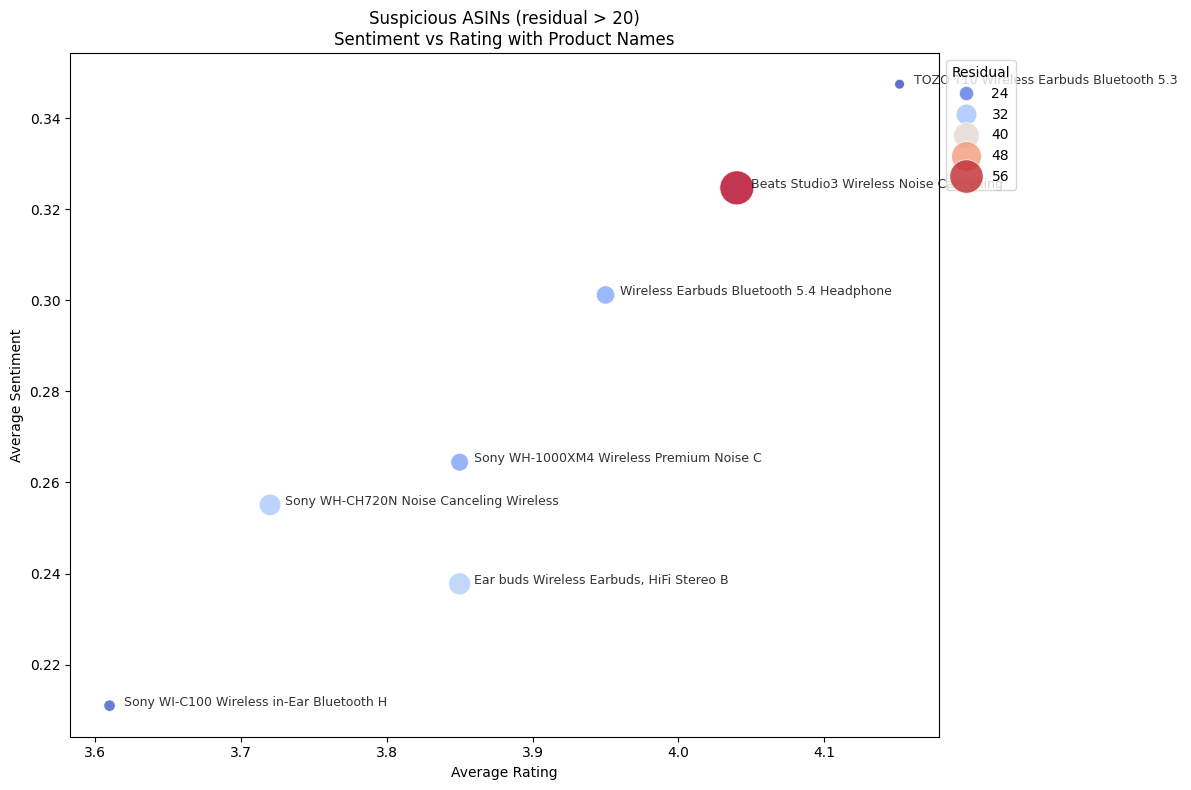

In [139]:


df['sentiment'] = df['body'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

# === ШАГ 3: Группировка по ASIN ===
df_grouped = df.groupby('asin', as_index=False).agg(
    avg_rating=('rating', 'mean'),
    review_count=('asin', 'count'),
    total_helpful_votes=('helpful_votes', 'sum'),
    avg_sentiment=('sentiment', 'mean'),
    product_name=('product_name', 'first')
)

# === ШАГ 4: Линейная регрессия ===
X = df_grouped[['avg_rating', 'review_count']]
y = df_grouped['total_helpful_votes']
model = LinearRegression().fit(X, y)
df_grouped['predicted_helpful_votes'] = model.predict(X)
df_grouped['residual'] = df_grouped['total_helpful_votes'] - df_grouped['predicted_helpful_votes']


# === ШАГ 6: Фильтрация по residual > 20 ===
df_filtered = df_grouped[df_grouped['residual'] > 20]

# === ШАГ 7: Визуализация ===
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_filtered,
    x='avg_rating',
    y='avg_sentiment',
    size='residual',
    hue='residual',
    palette='coolwarm',
    sizes=(50, 600),
    alpha=0.8
)

# Подписи product_name
for _, row in df_filtered.iterrows():
    plt.text(
        row['avg_rating'] + 0.01,
        row['avg_sentiment'],
        str(row['product_name'])[:40],
        fontsize=9,
        alpha=0.8
    )

plt.title('Suspicious ASINs (residual > 20)\nSentiment vs Rating with Product Names')
plt.xlabel('Average Rating')
plt.ylabel('Average Sentiment')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Residual')
plt.tight_layout()
plt.show()


#### IQR DETECTION


In [118]:



# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['helpful_votes'].quantile(0.25)
Q3 = df['helpful_votes'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df[(df['helpful_votes'] < lower_bound) | (df['helpful_votes'] > upper_bound)]

print("Outliers detected using IQR method:")
print(outliers_iqr)

Outliers detected using IQR method:
            asin             author           location       date  rating  \
18    B07J2Z5DBM            Anthony  the United States 2025-07-25     4.0   
19    B07J2Z5DBM     Estevan Aragon  the United States 2025-07-24     5.0   
20    B07J2Z5DBM  Doctor Felterbush  the United States 2025-07-24     5.0   
23    B07J2Z5DBM            Melissa  the United States 2025-07-24     4.0   
25    B07J2Z5DBM        "brdempsey"  the United States 2025-07-24     5.0   
...          ...                ...                ...        ...     ...   
4373  B0D2XRXNGY        G. Williams  the United States 2025-07-19     1.0   
4374  B0D2XRXNGY                 TJ  the United States 2025-07-19     4.0   
4378  B0D2XRXNGY    Amazon Customer  the United States 2025-07-18     1.0   
4383  B0D2XRXNGY   Michael L. Lewis  the United States 2025-07-17     4.0   
4384  B0D2XRXNGY               Rabr  the United States 2025-07-17     5.0   

                                       

#### DBSCAN
DBSCAN algorithm can detect outliers based on the density of data points. Outliers are those points that are not part of any cluster.

In [119]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

# Sample 2D data
data = np.array([[1, 2], [2, 2], [2, 3], [8, 7], [8, 8], [25, 80],[-100,2]])  # (25, 80) is an outlier

# Convert to DataFrame
df = pd.DataFrame(data, columns=['X', 'Y'])

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=3, min_samples=2)
df['Cluster'] = dbscan.fit_predict(data)

# Identify outliers (points with Cluster label -1 are outliers)
outliers_dbscan = df[df['Cluster'] == -1]

print("Outliers detected using DBSCAN:")
print(outliers_dbscan)


Outliers detected using DBSCAN:
     X   Y  Cluster
5   25  80       -1
6 -100   2       -1


#### Isolation Forest
Isolation Forest algorithm isolates observations by randomly selecting a feature and randomly splitting it between its minimum and maximum values. Points that can be isolated quickly are likely to be outliers.

In [63]:
from sklearn.ensemble import IsolationForest

data = np.array([10, 12, 12, 13, 12, 14, 15, 16, 18,-50,-5,30])  
df = pd.DataFrame(data, columns=['Values'])

# Apply Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
df['Anomaly'] = isolation_forest.fit_predict(df[['Values']])

# Identify outliers (points labeled -1 are outliers)
outliers_isolation = df[df['Anomaly'] == -1]

print("Outliers detected using Isolation Forest:")
print(outliers_isolation)

Outliers detected using Isolation Forest:
    Values  Anomaly
9      -50       -1
11      30       -1


## EDA (Exploratory Data Analysis)

### Feature Engineering (Create new features by existing feature)

In [74]:
#WORK AGAINST SPECIFIC VERSION OF TITANIC
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
titanic_df = pd.read_csv(url)

# 1. FamilySize (SibSp + Parch + 1)
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1

# 2. IsAlone (1 if the passenger is alone, 0 otherwise)
titanic_df['IsAlone'] = 1  # Default to alone
titanic_df['IsAlone'].loc[titanic_df['FamilySize'] > 1] = 0

# 3. Extract Title from the Name column
titanic_df['Title'] = titanic_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Group some titles into common categories (optional)
titanic_df['Title'] = titanic_df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs')

# 4.  Age Bins
titanic_df['AgeBin'] = pd.cut(titanic_df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=['Child', 'Teenager', 'Adult', 'Middle-aged', 'Senior'])

# 5.  Fare Bins
titanic_df['FareBin'] = pd.qcut(titanic_df['Fare'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title,AgeBin,FareBin,Deck,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr,Adult,Low,Unknown,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs,Middle-aged,Very High,C,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss,Adult,Medium,Unknown,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,Mrs,Adult,Very High,C,None
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,Mr,Adult,Medium,Unknown,None


### Aggregated analysis (by 1 or more features) (with plots when good)

### Cohort analysis (if suited)

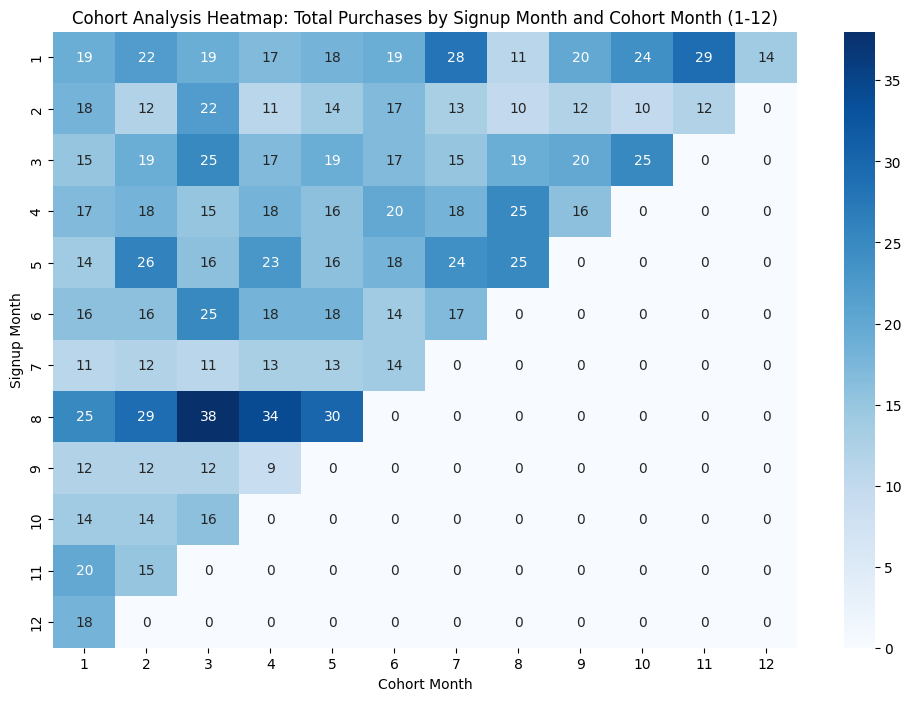

In [ ]:


# Simulate purchases in different months post-signup (1-12)
cohort_data = []
for customer_id, signup_month in zip(customer_ids, signup_months):
    for month in range(signup_month, n_months):
        purchases = np.random.randint(0, 4)  # Random number of purchases
        cohort_data.append({
            'customer_id': customer_id,
            'signup_month': signup_month + 1,  # Shift to 1-12
            'purchase_month': month + 1,  # Shift to 1-12
            'purchases': purchases
        })

cohort_df = pd.DataFrame(cohort_data)

# Add "cohort_month" (months since signup) starting from 1
cohort_df['cohort_month'] = cohort_df['purchase_month'] - cohort_df['signup_month'] + 1

# Create a cohort table showing total purchases per cohort and cohort_month
cohort_pivot = cohort_df.pivot_table(index='signup_month', columns='cohort_month', values='purchases', aggfunc='sum').fillna(0)

# Plot a heatmap for cohort analysis
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title('Cohort Analysis Heatmap: Total Purchases by Signup Month and Cohort Month (1-12)')
plt.xlabel('Cohort Month')
plt.ylabel('Signup Month')
plt.show()


### Geographical Analysis (Map plots, Real Estate Optimization for example)

In [ ]:
#WHAT WOULD YOU IMPROVE IN THE FOLLOWING PLOT?

In [46]:
import plotly.express as px
import plotly.io as pio

# Set renderer to open in the browser for interactive maps
pio.renderers.default = 'browser'

# Set a random seed for reproducibility
np.random.seed(42)

# Define the number of stores
num_stores = 6

# Define the latitude and longitude ranges for NYC area
lat_min, lat_max = 40.7120, 40.7180  # Latitude range around NYC
lon_min, lon_max = -74.0065, -74.0010  # Longitude range around NYC

# Generate random positions for stores within the NYC area
store_latitudes = np.random.uniform(lat_min, lat_max, size=num_stores)
store_longitudes = np.random.uniform(lon_min, lon_max, size=num_stores)

# Simulating marketplace data for stores
marketplace_data = {
    'Store': ['Supermarket', 'Butcher', 'Bakery', 'Pharmacy', 'Electronics Store', 'Clothing Store'],
    'Latitude': store_latitudes,
    'Longitude': store_longitudes,
    'Type': ['Grocery', 'Meat', 'Bakery', 'Health', 'Electronics', 'Clothing']
}

# Create a DataFrame from the marketplace data
marketplace_df = pd.DataFrame(marketplace_data)

# Simulating client locations in NYC around the stores (unchanged)
clients_data = {
    'Client': ['Client1', 'Client2', 'Client3', 'Client4', 'Client5', 'Client6'],
    'Latitude': [40.7125, 40.7135, 40.7145, 40.7155, 40.7165, 40.7175],  # Client Latitudes
    'Longitude': [-74.0065, -74.0055, -74.0045, -74.0035, -74.0025, -74.0015]  # Client Longitudes
}

# Create a DataFrame for client data
clients_df = pd.DataFrame(clients_data)

# 1. Marketplace visualization: Plot stores with types on a local NYC map with bigger markers
fig_marketplace = px.scatter_mapbox(
    marketplace_df, 
    lat="Latitude", 
    lon="Longitude", 
    text="Store", 
    color="Type", 
    size_max=20,  # Increase the size of markers
    zoom=13,  # Zoom to NYC level
    title="Marketplace Store Visualization",
    mapbox_style="open-street-map"
)

# Increase the marker size for better visibility (unchanged)
fig_marketplace.update_traces(marker=dict(size=15))  # Larger dots

# Customize the marketplace plot (unchanged)
fig_marketplace.update_layout(
    title=dict(text='Marketplace Store Visualization in NYC', x=0.5),
    mapbox=dict(center=dict(lat=40.715, lon=-74.004), zoom=14)  # Center on NYC
)
# Show both visualizations (marketplace and clients)
fig_marketplace.show()

### Statistical Analysis (Formulate Hypothesis, Statistical testing (different tests for different cases))

#### T-TEST :Compare the average sales revenue between Region A and Region B.

In [45]:
from scipy import stats

# Sample data for sales in Region A and Region B
sales_region_A = np.array([100, 120, 130, 150, 110, 160, 140])
sales_region_B = np.array([90, 95, 105, 85, 100, 110, 95])

# Perform a two-sample t-test (assuming unequal variances)
t_stat, p_value = stats.ttest_ind(sales_region_A, sales_region_B, equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis, significant difference in means.")
else:
    print("Fail to reject the null hypothesis, no significant difference in means.")


T-statistic: 3.739301920763493
P-value: 0.005906402344865854
Reject the null hypothesis, significant difference in means.


#### Chi-Square Test - test if the click-through rate (CTR) for two email campaigns is different.

In [44]:
from scipy.stats import chi2_contingency

# Create a contingency table (clicks and non-clicks for two versions)
# Rows represent Version X and Version Y, columns represent click/no-click
contingency_table = np.array([[50, 450],  # Version X
                              [30, 470]])  # Version Y

# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis, significant difference in CTR.")
else:
    print("Fail to reject the null hypothesis, no significant difference in CTR.")


Chi-Square Statistic: 4.904891304347827
P-value: 0.026780737077995442
Reject the null hypothesis, significant difference in CTR.


#### Shapiro-Wilk Test: Testing for Normality

In [43]:
from scipy.stats import shapiro

# Sample salary data
salaries = np.array([55, 60, 70, 65, 80, 75, 85, 90, 95, 100])

# Perform Shapiro-Wilk test for normality
stat, p_value = shapiro(salaries)

print(f"Shapiro-Wilk Statistic: {stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis, data is not normally distributed.")
else:
    print("Fail to reject the null hypothesis, data is normally distributed.")


Shapiro-Wilk Statistic: 0.9701646110856056
P-value: 0.8923673061902978
Fail to reject the null hypothesis, data is normally distributed.


## ETL (Extract, Transform, Load)

## Summary & Conclusions

#### Technical Conclusions:

#### Buisness Conclusions:

#### Dashboard \ Presentation link: